# Arabic Sign Language Recognition using CNNs

## Introduction

This notebook details the implementation of a neural network using PyTorch to recognize Arabic Sign Language alphabets.  The goal is to contribute to improving accessibility and communication for those who use sign language.

## 1. Dataset Details: ArASL

This project utilizes the ArASL (Arabic Alphabets Sign Language Dataset).  This dataset contains images of hand signs representing the Arabic alphabet.

- **Total Images:** 54,049
- **Classes:** 32 (representing the Arabic alphabet)

## 2. Label Representation

Each image is associated with a numerical label representing a specific Arabic character.  These labels are integers ranging from 0 to 31.

## 3. Character Mapping

The mapping between numerical labels and corresponding Arabic characters is defined in the `mapping` variable (see code).  The mapping is also provided below for reference:

0: 'seen', 1: 'zay', 2: 'aleff', 3: 'dal', 4: 'ta', 5: 'yaa', 6: 'fa', 7: 'ya', 8: 'khaa', 9: 'nun', 10: 'ha', 11: 'toot', 12: 'taa', 13: 'ra', 14: 'kaaf', 15: 'jeem', 16: 'laam', 17: 'la', 18: 'dhad', 19: 'dha', 20: 'waw', 21: 'meem', 22: 'al', 23: 'sheen', 24: 'haa', 25: 'thaa', 26: 'saad', 27: 'ghain', 28: 'ain', 29: 'thal', 30: 'gaaf', 31: 'bb'

## 4. Reference

Latif, G., Mohammad, N., Alghazo, J., AlKhalaf, R., & AlKhalaf, R. (2019). ARASL: Arabic Alphabets Sign Language Dataset. *Data in Brief*, 23, 103777. https://doi.org/10.1016/j.dib.2019.103777

## 5. Instructions

Your task is to do the following:

1. **Classification Model:**
    * Design and implement a CNN architecture for classification.
    * Train the model using the `DataLoaders`.
    * Evaluate the model and show the results.
2. **Autoencoder:**
    * Design and implement a CNN-based autoencoder (encoder-decoder).
    * Train the autoencoder using the `DataLoader`.
    * Evaluate the model and show the results.


In [1]:
from IPython.display import clear_output

In [2]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install torchvision
%pip install matplotlib

clear_output()

In [3]:
# importing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt

## Downloading the dataset

### Run the following cells to download the ArASL dataset.

In [4]:
!gdown https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded

Downloading...
From: https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded
To: /content/file_downloaded
100% 66.2M/66.2M [00:02<00:00, 28.0MB/s]


In [5]:
!unzip file_downloaded
clear_output()

## Just run these two cells. You are not supposed to explore them.

In [6]:
import os

def rename_folders_and_create_mapping(folder_path):
    # Get the list of folders in the specified path
    folders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    # Create a mapping from original folder names to numbers
    folder_mapping = {folder: i for i, folder in enumerate(folders)}

    # Rename the folders in-place and store the original names in the mapping
    for original_folder, number in folder_mapping.items():
        new_folder_name = str(number)
        new_folder_path = os.path.join(folder_path, new_folder_name)

        # Rename the folder
        os.rename(os.path.join(folder_path, original_folder), new_folder_path)

    return folder_mapping

folder_path = 'ArASL_Database_54K_Final'

# Create the folder mapping and rename folders
mapping = rename_folders_and_create_mapping(folder_path)

# Print the folder mapping
print("Folder Mapping:")
print(mapping)


Folder Mapping:
{'ghain': 0, 'toot': 1, 'fa': 2, 'ra': 3, 'al': 4, 'dha': 5, 'haa': 6, 'waw': 7, 'laam': 8, 'taa': 9, 'bb': 10, 'saad': 11, 'meem': 12, 'thal': 13, 'ha': 14, 'ta': 15, 'khaa': 16, 'zay': 17, 'nun': 18, 'la': 19, 'thaa': 20, 'dhad': 21, 'dal': 22, 'yaa': 23, 'ya': 24, 'sheen': 25, 'gaaf': 26, 'kaaf': 27, 'ain': 28, 'seen': 29, 'jeem': 30, 'aleff': 31}


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None, target_size=(28, 28)):
        self.root_folder = root_folder
        self.transform = transform
        self.target_size = target_size

        # Get the list of image files
        self.image_files = []
        self.image_labels = []

        for root, dirs, files in os.walk(root_folder):
            for file in files:
                if file.lower().endswith('.jpg'):
                    self.image_files.append(os.path.join(root, file))
                    self.image_labels.append(int(os.path.basename(root)))

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.image_labels[idx]

        # Convert label to tensor
        # print("Label", label, type(label))
        label = torch.tensor(label)

        # Open the image
        with Image.open(img_path) as img:
            # Convert the image to grayscale
            img = img.convert('L')

            # Resize the image
            img = img.resize(self.target_size)

            # Apply additional transformations if specified
            if self.transform:
                img = self.transform(img)

            return (img, label)

# Define the root folder and output folder
root_folder_path = 'ArASL_Database_54K_Final'


# Define transformations (resize to 28x28 and convert to tensor)
data_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
custom_dataset = CustomDataset(root_folder_path, transform=data_transform)

from torch.utils.data import random_split

# Define the size of the training and validation sets
total_size = len(custom_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

mapping = {v:k for k,v in mapping.items()}

## Exploring the data

#### Here is the mapping for each class and its encoding. In addition to the train_dataset and val_dataset

In [8]:
train_dataset # Contains the training ArASL_Database_54K_Final dataset (80%)

val_dataset  # Contains the validating ArASL_Database_54K_Final dataset (20%)


print("The mapping between the letters and the encoding: \n", mapping)
print('Length of train_dataset is', len(train_dataset))
print('Length of val_dataset is'  , len(val_dataset))

The mapping between the letters and the encoding: 
 {0: 'ghain', 1: 'toot', 2: 'fa', 3: 'ra', 4: 'al', 5: 'dha', 6: 'haa', 7: 'waw', 8: 'laam', 9: 'taa', 10: 'bb', 11: 'saad', 12: 'meem', 13: 'thal', 14: 'ha', 15: 'ta', 16: 'khaa', 17: 'zay', 18: 'nun', 19: 'la', 20: 'thaa', 21: 'dhad', 22: 'dal', 23: 'yaa', 24: 'ya', 25: 'sheen', 26: 'gaaf', 27: 'kaaf', 28: 'ain', 29: 'seen', 30: 'jeem', 31: 'aleff'}
Length of train_dataset is 43239
Length of val_dataset is 10810


In [9]:
batch_size = 64

# DataLoaders simplify the job of grouping the samples into batches.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

## Let's visualize an image and its channels

The image shape: torch.Size([1, 48, 48])
Number of channels in image:  1
The image label: 9 taa


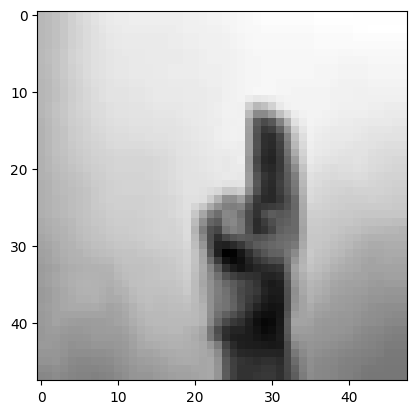

In [10]:
random_img_idx = 30 # Write any random index (between 0 and 59999)

image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
label = train_dataset[random_img_idx][1]  # 1 for label part

print("The image shape:", image.shape)
print('Number of channels in image: ', image.shape[0]) # 1 channel (layer) for black-white images.
print("The image label:", label.item(), mapping[label.item()])

plt.imshow(image.reshape(48, 48), cmap='gray')

### Create a loop to show 10 different images ranodmly

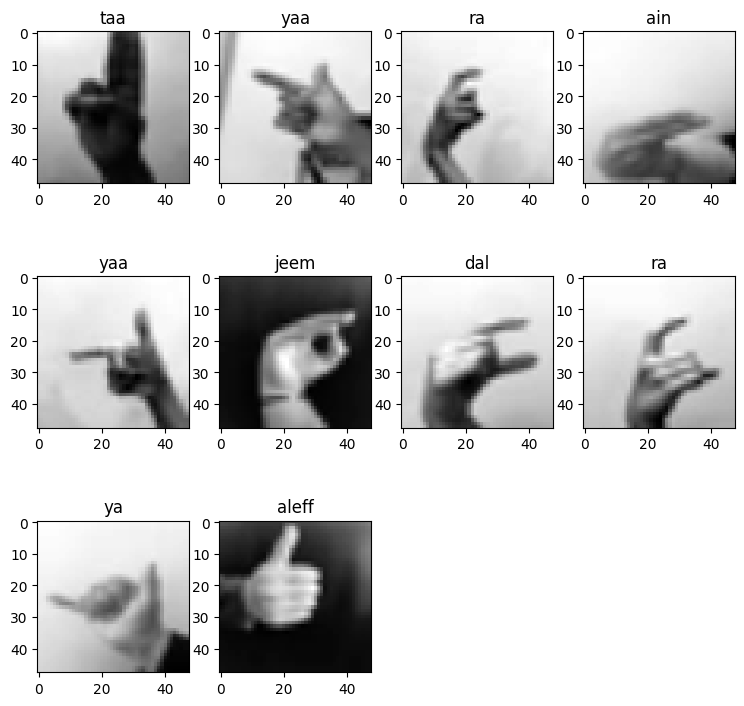

In [11]:
import random

# create figure
fig = plt.figure(figsize=(9, 9))

for i in range(10):
    random_img_idx = random.randint(0, 43238) # Write any random index (between 0 and 43238)

    image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
    label = train_dataset[random_img_idx][1]  # 1 for label part

    # Adds a subplot at the 2nd position
    fig.add_subplot(3, 4, i+1)
    plt.title(mapping[label.item()])
    plt.imshow(image.reshape(48, 48), cmap='gray')

This challenge is made by [Hassan Alsayhah](https://www.linkedin.com/in/hassan-alsayhah-28a83a251/) & [Ali Alqutayfi](https://www.linkedin.com/in/ali-alqutayfi/)